## 전이 학습(Transfer Learning) : COVID-19를 흉부 X-ray로 탐지하기  
- 흉부 X-ray 이미지 분류: 세 가지 클래스 중 하나로 분류 - Normal, Viral Pneumonia, COVID-19 (정상, 바이러스성 폐렴, COVID-19)  

- 사전 학습된 ResNet18 모델을 불러와 마지막 Fully Connected (FC) 레이어를 수정하여 출력 클래스 수를 3개로 변경.

- 데이터셋: Kaggle의 COVID-19 Radiography Dataset (https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database) 사용

 --> COVID-19 양성 사례 3616장, 정상 10,192장, 폐 혼탁(비COVID 폐 감염) 6012장, 바이러스성 폐렴 1345장의 이미지와 해당 폐 마스크 포함.

In [1]:
import os
import shutil
import random
import torch
import torchvision
from torch import nn
from torchvision import datasets
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(device)

mps


In [3]:
# !gdown 1ql4oc0aAKL3Aw7q-6XwfD_ZaK9bPh9Wl -O covid.zip

In [4]:
# !unzip -q covid.zip -d ./data

In [5]:
data_dir = 'data/COVID-19 Radiography Database'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print(os.listdir(data_dir))
print(os.listdir(train_dir))
print(os.listdir(test_dir))

['test', 'train']
['normal', 'viral', 'covid']
['normal', 'viral', 'covid']


In [6]:
from torchvision import transforms

# 학습용 데이터 변환 설정
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 테스트용 데이터 변환 설정
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### `datasets.ImageFolder(folder, transform)` data loader 생성

In [7]:
# datasets.ImageFolder를 사용하여 훈련 데이터셋을 로드
# 이 함수는 주어진 디렉토리 경로에서 이미지 파일들을 자동으로 찾아서 레이블을 할당
# data_dir은 데이터가 저장된 루트 디렉토리
# 'train' 폴더 안에 있는 이미지들은 훈련을 위해 사용
train_data = datasets.ImageFolder(train_dir, train_transform)

test_data = datasets.ImageFolder(test_dir, test_transform)

In [8]:
len(train_data), len(test_data)

(2816, 90)

In [9]:
batch_size = 8

# 학습 데이터 로더 생성
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

# 테스트 데이터 로더 생성
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

# 학습 및 테스트 배치 수 출력
print('Number of training batches', len(train_loader)) # 학습 데이터 배치 개수 출력
print('Number of test batches', len(test_loader)) # 학습 데이터 배치 개수 출력

Number of training batches 352
Number of test batches 12


## 데이터 시각화

In [10]:
# 클래스 이름 가져오기 (정상, 바이러스성 폐렴, COVID-19)
class_names = train_data.classes
class_names

['covid', 'normal', 'viral']

In [11]:
# 이미지를 보여주는 함수 정의
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))

    # 각 이미지를 순회하며 표시
    for i, image in enumerate(images):
        plt.subplot(1, 8, i + 1, xticks=[], yticks=[])
        image = image.permute((1, 2, 0)).numpy()

        # 정규화 해제를 위한 평균 및 표준편차 설정
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean # 정규화 해제
        image = np.clip(image, 0., 1.) # 이미지 값을 0과 1사이로 클리핑

        plt.imshow(image)

        # 예측이 틀린 경우 레이블 색상을 빨간색으로 설정
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        # 실제 클래스 레이블과 예측 클래스 레이블 표시
        plt.xlabel(f'{class_names[labels[i].item()]}')
        plt.ylabel(f'{class_names[preds[i].item()]}', color=col)

    plt.tight_layout()
    plt.show()  


torch.Size([8, 3, 224, 224]) torch.Size([8])


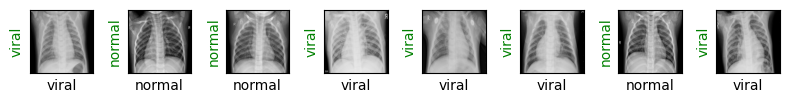

In [12]:
# 학습 데이터 로더에서 첫 번째 배치의 이미지와 레이블을 가져옴
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

# 이미지와 실제 레이블을 사용하여 이미지 표시 함수 호출 (예측 값은 실제 레이블로 설정)
show_images(images, labels, labels)

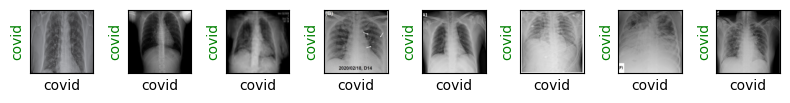

In [13]:
images, labels = next(iter(test_loader))

show_images(images, labels, labels)

## Model 생성

In [14]:
resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# ResNet18 모델의 최종 완전 연결(FC) 레이어를 수정하여 출력 클래스 수를 3으로 설정 (normal, viral, covid)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

resnet18.to(device)

# 손실 함수로 교차 엔트로피 손실 설정
criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 설정, 학습률은 3e-5로 설정
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

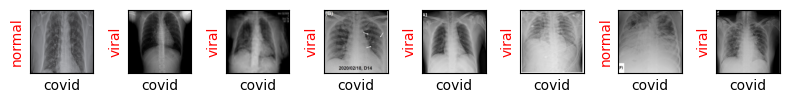

In [16]:
# 예측 결과를 시각화하는 함수 정의
def show_preds():
    resnet18.eval()
    
    images, labels = next(iter(test_loader))
    images = images.to(device)

    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)

    show_images(images.cpu(), labels, preds.cpu())

# 예측 결과 시각화 함수 호출
show_preds()

-> 전이학습을 하지않은 결과이므로 결과가 좋지않음

## Model 학습

0/3:   0%|          | 0/352 [00:00<?, ?it/s]

Step 0에서 검증 수행 중..
Validation Loss: 1.2182, Accurac:  0.3000


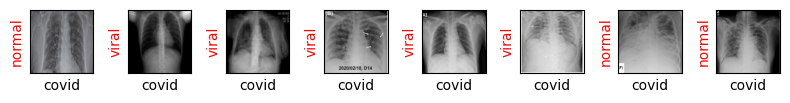

0/3:   5%|▌         | 19/352 [00:29<01:20,  4.11it/s] 

Step 20에서 검증 수행 중..


0/3:   5%|▌         | 19/352 [00:40<01:20,  4.11it/s]

Validation Loss: 0.6289, Accurac:  0.7889


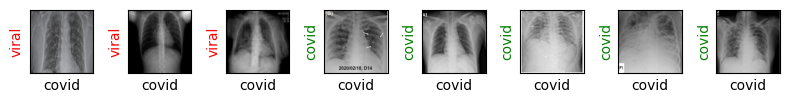

0/3:  11%|█         | 39/352 [00:58<01:14,  4.20it/s]

Step 40에서 검증 수행 중..


0/3:  11%|█         | 39/352 [01:10<01:14,  4.20it/s]

Validation Loss: 0.4046, Accurac:  0.9222


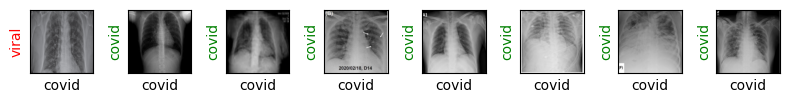

0/3:  17%|█▋        | 59/352 [01:33<01:19,  3.69it/s]

Step 60에서 검증 수행 중..


0/3:  17%|█▋        | 59/352 [01:50<01:19,  3.69it/s]

Validation Loss: 0.2760, Accurac:  0.9333


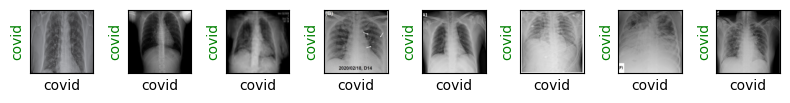

0/3:  22%|██▏       | 79/352 [02:12<01:22,  3.32it/s]

Step 80에서 검증 수행 중..


0/3:  22%|██▏       | 79/352 [02:30<01:22,  3.32it/s]

Validation Loss: 0.2333, Accurac:  0.9333


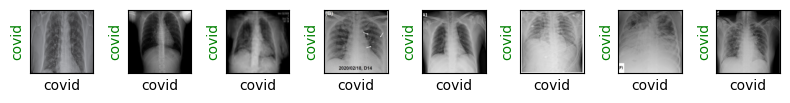

0/3:  28%|██▊       | 99/352 [02:42<01:00,  4.16it/s]

Step 100에서 검증 수행 중..


0/3:  28%|██▊       | 99/352 [03:00<01:00,  4.16it/s]

Validation Loss: 0.1902, Accurac:  0.9444


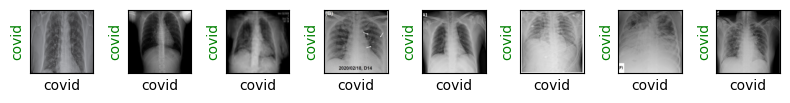

0/3:  34%|███▍      | 119/352 [03:16<01:01,  3.76it/s]

Step 120에서 검증 수행 중..


0/3:  34%|███▍      | 119/352 [03:30<01:01,  3.76it/s]

Validation Loss: 0.1611, Accurac:  0.9667


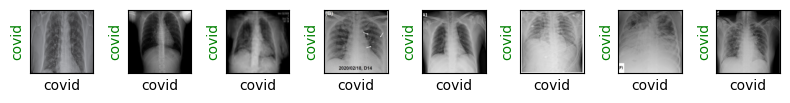

0/3:  34%|███▍      | 120/352 [03:44<07:13,  1.87s/it]

성능 기준 충족으로 조기 종료.....


Training Loss: 0.1460


In [17]:
from tqdm import tqdm

epochs = 3
early_stop = False

for epoch in range(epochs):
    train_loss = 0.0

   # 학습 데이터 반복
    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f'{epoch}/{epochs}'):        
        images = images.to(device)
        labels = labels.to(device)
        
        resnet18.train()

        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        # 일정 스텝마다 검증 수행
        if step % 20 == 0:
            print(f'Step {step}에서 검증 수행 중..')

            resnet18.eval()
            val_loss = 0.0
            correct = 0

            with torch.no_grad():
                for val_step, (images, labels) in enumerate(test_loader):
                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = resnet18(images)
                    loss = criterion(outputs, labels) 
                    val_loss += loss.item() * images.size(0)

                    _, preds = torch.max(outputs, 1)
                    correct += (preds == labels).sum().item()
            
            val_loss /= len(test_loader.dataset)
            accuracy = correct / len(test_loader.dataset)

            print(f'Validation Loss: {val_loss:.4f}, Accurac: {accuracy: .4f}')
            show_preds()
            
            # 조기 종료 조건 확인
            if accuracy >= 0.95:
                print('성능 기준 충족으로 조기 종료.....')
                early_stop = True
                break
        
    train_loss /= len(train_loader.dataset)
    print(f'Training Loss: {train_loss:.4f}')

    if early_stop:
        break